# Ensemble Learning

* The basic idea of ensemble learning is to have multiple learning algorithms for the same problem and combine their results to make a final prediction

* There are multiple types on ensemble learning.  Common approaches include:
    * Boosting 
    * Bagging/Bootstrapping
    * Random Forests
    * Mixture of Experts
    
## Boosting and Bagging

* When you have one data set, usually you may train an algorithm and learn a single set of parameters.  However, when we do this, we have no idea how stable/variable those parameters that we estimated are. 
* Bootstrapping can show us the variation in estimated parameter values given a particular data set. Sometimes, it can also help to improve our predictions. 
* Essentially, to perform bootstrapping, you sample from your data set *with replacement* and train your algorithm to estimate the parameters with each sampled subset.  You can then look at how much the parameters vary with each sampled subset and you can also combine your estimates from each trained method by averaging over all of the results for regression:
\begin{equation}
y_{com}(\mathbf{x}) = \frac{1}{M} \sum_{m=1}^M y_m(\mathbf{x})
\end{equation}
* You can aggregate results over all your bootstrap samples using majority vote for classification.

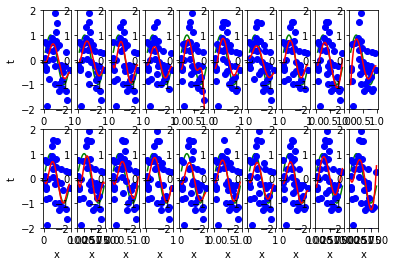

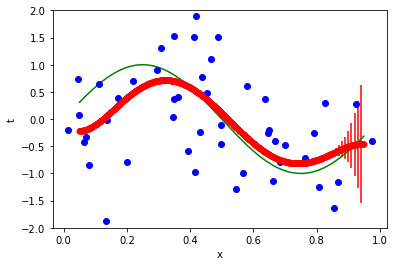

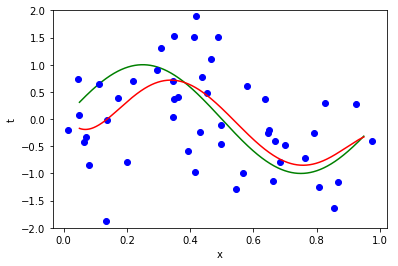

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import textwrap
%matplotlib inline


def generateRandData(N, l, u, gVar):
	'''generateRandData(N, l, u, gVar): Generate N uniformly random data points in the range [l,u) with zero-mean Gaussian random noise with variance gVar'''
	x = np.random.uniform(l,u,N)
	e = np.random.normal(0,gVar,N)
	t = np.sin(2*math.pi*x) + e
	return x,t

def fitdataReg(x,t,M,la):
	'''fitdata(x,t,M): Fit a polynomial of order M to the data (x,t)'''	
	X = np.array([x**m for m in range(M+1)]).T
	w = np.linalg.inv(X.T@X+(la*np.identity(M+1)))@X.T@t
	return w

def plotPoly(x,t,xrange, y, esty, subplotloc,la=0):
	#plot everything
	plt.subplot(*subplotloc) #identify the subplot to use
	# plt.tight_layout()
	plt.ylim([-2,2])
	p1 = plt.plot(xrange, y, 'g') #plot true value
	p2 = plt.plot(x, t, 'bo') #plot training data
	p3 = plt.plot(xrange, esty, 'r') #plot estimated value

	#add title, legend and axes labels
	plt.ylabel('t') #label x and y axes
	plt.xlabel('x')

def bootstrapRegression(M, numData,percentSample,numSamples):
    
    #generate data
	x,t = generateRandData(numData,0,1,1) 
	numDataSamples = round(percentSample*numData)
	subplotloc = [2, round(numSamples/2), 1]
	fig = plt.figure()
	xrange = np.arange(0.05,.95,0.001)  #get equally spaced points in the xrange
	esty = np.empty([numSamples, xrange.shape[0]])
    
	for iter in range(numSamples):
        #select a random subset of the data
		rp = np.random.permutation(numData)
		x_sub = x[rp[0:numDataSamples-1]]
		t_sub = t[rp[0:numDataSamples-1]]
        
        #fit the random subset
		w = fitdataReg(x_sub,t_sub,M,0)
        
        #plot results
		subplotloc[2] = iter+1
		y = np.sin(2*math.pi*xrange) #compute the true function value
		X = np.array([xrange**m for m in range(w.shape[0])]).T
		esty[iter,:] = X@w #compute the predicted value
		plotPoly(x_sub,t_sub,xrange,y,esty[iter,:],subplotloc)
        
    
    #combine the bootstrapped results
	comy = esty.mean(0)
	yerr = esty.var(0)

    # compare to full data set
	fig = plt.figure()
	plotPoly(x,t,xrange,y,comy,[1, 1, 1])
	plt.errorbar(xrange, comy, yerr=yerr, fmt='r.',ms=10,errorevery=10)

	fig = plt.figure()
	w = fitdataReg(x,t,M,0)
	y = np.sin(2*math.pi*xrange) #compute the true function value
	X = np.array([xrange**m for m in range(w.shape[0])]).T
	yy = X@w #compute the predicted value
	plotPoly(x,t,xrange,y,yy, [1, 1, 1])
    


#Figure 1.7 from text
bootstrapRegression(5, 50,.75,20)
        

# Boosting: AdaBoost

* Goal:  Combine base (``weak'') classifiers to form a committee whose performance is better than any of the single base classifiers. 
* The base classifiers are trained in sequence (not in parallel like in bootstrapping)
* Each base classifier is trained using a weighted data set (different weights for each base classifier)
* Points that are misclassified by a base classifier are weighted more heavily while training the next base classifier

* Consider a two class classification problem with $\mathbf{X} = \left\{ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n\right\}$ with corresponding labels $y_i \in \left\{ -1,1\right\}$.
* The goal is to construct a classifier of the form: 
\begin{equation}
f(\mathbf{x}) = sign(F(\mathbf{x}))
\end{equation}
where
\begin{equation}
F(\mathbf{x}) = \sum_{k=1}^K \frac{1}{2}\alpha_k \phi(\mathbf{x}; \theta_k)
\end{equation}
where $\phi(\mathbf{x}; \theta_k)$ is the base classifier. 


* We need to determine the parameter values for each base classifier:
\begin{eqnarray}
\arg \min_{\alpha_k, \theta_k} \sum_{i=1}^N \exp\left(-y_i F(\mathbf{x}_i) \right)
\end{eqnarray}
* This cost function penalizes the samples that are incorrectly classified ($y_iF(\mathbf{x}_i) < 0$) heavily 
* Direct optimization of all $\alpha$s and $\theta$s is difficult.   So, we iteratively optimize (which is sub-optimal). At each stage, we train one base classifier holding fixed all those that have already been trained. 


* Let:
\begin{eqnarray}
F_m(\mathbf{x}) &=& \sum_{k=1}^m \frac{1}{2}\alpha_k \phi(\mathbf{x}; \theta_k)\\
&=& F_{m-1}(\mathbf{x}) + \frac{1}{2}\alpha_m \phi(\mathbf{x}; \theta_m)
\end{eqnarray}
* At step $m$, we optimize for $\alpha_m$ and $\theta_m$ where $F_{m-1}(\mathbf{x})$ is fixed:
\begin{eqnarray}
(\alpha_m, \theta_m) &=& \arg \min_{\alpha, \theta} J(\alpha, \theta)\\
&=& \arg \min_{\alpha, \theta} \sum_{i=1}^N \exp\left( -y_i\left( F_{m-1}(\mathbf{x}_i) +\frac{1}{2} \alpha\phi(\mathbf{x}_i; \theta)\right)\right)
\end{eqnarray}
* So, let's optimize this in two steps: first $\theta_m$ and then $\alpha_m$
\begin{eqnarray}
\theta_m &=&  \arg \min_{\theta} \sum_{i=1}^N \exp\left( -y_i\left( F_{m-1}(\mathbf{x}_i) + \frac{1}{2}\alpha\phi(\mathbf{x}_i; \theta)\right)\right)\\
&=& \arg \min_{\theta} \sum_{i=1}^N w_i^{(m)} \exp\left( -\frac{1}{2}y_i\alpha\phi(\mathbf{x}_i; \theta)\right)
\end{eqnarray}
where
\begin{equation}
w_i^{(m)} = \exp\left(-y_iF_{m-1}(\mathbf{x}_i)\right)
\end{equation}



* This can be re-written as: 

\begin{eqnarray}
\theta_m &=&  \arg \min_{\theta} \exp\left(-\alpha_m/2\right)\sum_{n \in T_m}w_n^{(m)} + \exp\left(\alpha_m/2\right)\sum_{n \in M_m}w_n^{(m)} \nonumber \\
&=& \left( \exp\left(\alpha_m/2\right) - \exp\left(-\alpha_m/2\right)\right)\sum_{i=1}^Nw_i^{(m)} I(\phi_m(\mathbf{x}_i;\theta) \ne y_i) + \exp\left(-\alpha_m/2\right)\sum_{i=1}^Nw_i^{(m)}
\end{eqnarray}

* This is equivalent to minimizing

\begin{equation}
\arg \min_{\theta} \sum_{i=1}^N w_i^{(m)} I(\phi_m(\mathbf{x}_i;\theta) \ne y_i)
\end{equation}




* Once we have the optimal classifier at step $m$ (i.e., $\theta_m$), then we determine the $\alpha_m$ values
\begin{eqnarray}
\sum_{y_i\phi(\mathbf{x}_i;\theta_m)<0}w_i^{(m)} = P_m\\
\sum_{y_i\phi(\mathbf{x}_i;\theta_m)>0}w_i^{(m)} = 1 - P_m
\end{eqnarray}
* Plugging this into J, we get:
\begin{eqnarray}
\alpha_m = \arg\min_{\alpha} \left\{ \exp(-\alpha)(1-P_m) + \exp(\alpha)P_m\right\}
\end{eqnarray}
* Take the derivative with respect to $\alpha$, set to zero, we get: 
\begin{equation}
\alpha_m = \frac{1}{2}\ln\frac{1-P_m}{P_m}
\end{equation}
* Once you get $\theta_m$ and $\alpha_m$, you compute the weights for the next step:
\begin{equation}
w_i^{(m+1)} = \frac{\exp(-y_iF_m(\mathbf{x}_i))}{Z_m} = \frac{\exp(-y_i\alpha_m\phi(\mathbf{x}_i;\theta_m))}{Z_m} 
\end{equation}
where
\begin{equation}
Z_m = \sum_{i=1}^N w_i^{(m)}\exp\left(-y_i\alpha_m\phi(\mathbf{x}_i;\phi_m)\right)
\end{equation}
* Notice that the weight corresponding to a sample is increased (or decreased) with respect to its value in the previous iteration
* Notice that the amount of increase or decrease depends on $\alpha_m$ which controls the relative importance of the $m^{th}$ term in building up the final classifier




## Random Forests
* A forest is made up of many trees...
* For classification/regression, put an input vector down each of the trees in the forest.  For classification, classify the data point using majority vote.  For regression, average the values
* Each tree is grown using:
    * Sample $N$ data points (with replacement, i.e., a bootstrap sample) from the full training data set
    * Specify a number $d << D$.  $d$ variables are selected at random out of all $D$ features to determine the split on the node.  Select the best of the $d$ features to split at that node
    * Grow each tree as much as possible (i.e., no pruning or stopping early)

* Error relates to correlation between the trees.  Greater correlation leads to greater error.  *Does this make sense?*
* Error also relates to the strength of each individual tree.  Better individual trees lead to lower error
* https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm


# Dropout

* This is a method to help prevent overfitting and regularize a network.
* The approach attempts to minimize co-dependencies between neurons and enhance robustness of network
* Dropout has one parameter $p$.  In each iteration, you randomly exclude each neuron with probability $1-p$ during the training pass (in both forward and backward propagation).  Each iteration, you resample which neurons to keep and which to dropout. 
* Dropout is related to the concept of ensemble learning with the unique case that the various models in the ensemble share parameters and these models are "combined" into a single model/network at test as opposed to training a fusion model or doing a simple average between outputs. 
* During test, you use all neurons all the time. 
* Please see and read: https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf